# Soft-sensor para predecir las concentraciones de producto en el proceso de cracking de etileno

En este caso se presentan unos datos con una frecuencia 10 minutal y se trata de usar técnicas de anlíotica de datos y machine learning para desarrollar un soft-sensor con el objetivo tener un análisis de backup que es crítico para el proceso. Las concentraciones a predecir son:
H2		Hidrógeno
CH4     Metano
C2H4	Etileno
C3H6	Propileno

## Opciones para pruebas
### Utilizar estas variables para probar diferentes opciones del algoritmo

In [6]:
### Variable objetivo a modelizar [Opciones --> H2_B /CH4_B / C2H4_B / C3H6_B] ###
target = 'CH4_B'

### Suavizado de las variables [Opciones --> True / False] ###
smoothing = True

### Realizar análisis de componentes principales [Opciones --> True / False] ###
pca_select = False

### Seleccionar el modelo a usar para la inferencia [Opciones --> RandomForest / GradientBoosting] ###
model_select = 'RandomForest'

# Carga de datos con frecuencia 10 minutal de variables y concentraciones

In [2]:
import pandas as pd
import utils as u
file_name = 'data/long_data.csv'
df = pd.read_csv(file_name, sep=',', header = 0, index_col = 0, parse_dates=True,date_parser=u.dateparse)
df = df.rename(columns = u.translation)
targets = ['H2_B', 'CH4_B', 'C2H4_B', 'C3H6_B']
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11663 entries, 2016-10-01 00:10:00 to 2016-12-20 23:50:00
Data columns (total 42 columns):
Caudal_naphta       11663 non-null float64
Caudal_vapor        11663 non-null float64
Temp_Coil_4_htc1    11663 non-null float64
Temp_Coil_3_htc1    11663 non-null float64
Temp_Coil_2_htc1    11663 non-null float64
Temp_Coil_1_htc1    11663 non-null float64
Temp_Coil_5_htc1    11663 non-null float64
Temp_Coil_6_htc1    11663 non-null float64
Temp_Coil_7_htc1    11663 non-null float64
Temp_Coil_8_htc1    11663 non-null float64
Temp_Coil_1_htc2    11663 non-null float64
Temp_Coil_2_htc2    11663 non-null float64
Temp_Coil_3_htc2    11663 non-null float64
Temp_Coil_4_htc2    11663 non-null float64
Temp_Coil_8_htc2    11663 non-null float64
Temp_Coil_7_htc2    11663 non-null float64
Temp_Coil_6_htc2    11663 non-null float64
Temp_Coil_5_htc2    11663 non-null float64
Temp_Sal_Humos_1    11663 non-null float64
Temp_Sal_Humos_2    11663 non-null floa

### Visualizar las variables target

<Figure size 1440x720 with 0 Axes>

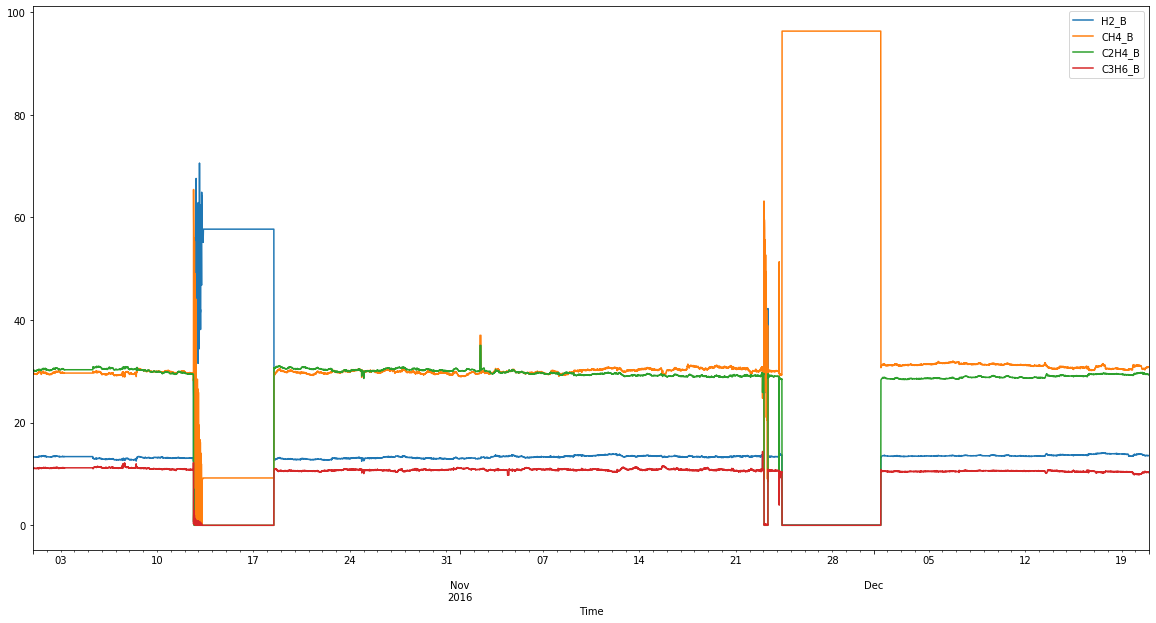

In [9]:
import matplotlib.pylab as plt
ax = plt.figure(figsize=(20,10))
#sns.lineplot(data=df[targets])
df[targets].plot(figsize=(20,10))
plt.show()

## Data Cleaning / Limpieza de datos
### Desviación absoluta de la mediana normalizada (MAD)
#### MAD(x) =Μedian(|xi -M(x)|)/0.6745

In [12]:
import numpy as np
window = 900
clean_data = df.copy()
for input in clean_data[u.all_labels].columns:
    clean_data = clean_data[clean_data.columns][np.invert(u.mad_based_outlier(clean_data[input],3))]

print (clean_data.shape)

(8536, 42)


### Visualización del proceso de data cleansing

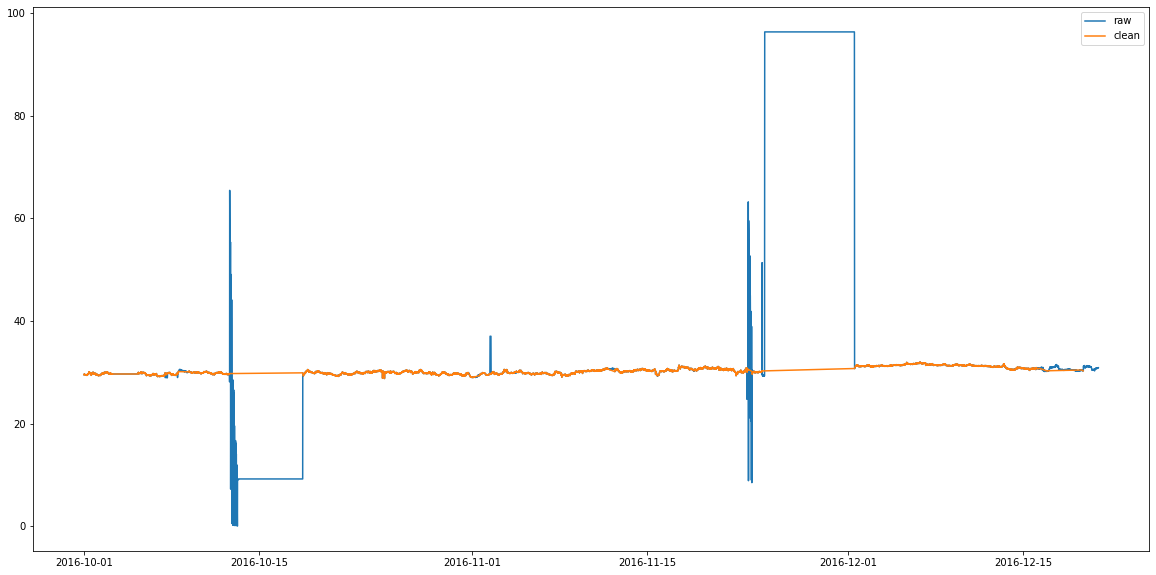

In [14]:
plt.figure(figsize=(20,10))
plt.plot(df[target],label='raw')
plt.plot(clean_data[target],label='clean')
plt.legend()
plt.show()

## Preparar datos de Entrenamiento y de Test
### Es conveniente trabajar la parametrización del algoritmo con los datos de entrenamiento y dejar para el final un set de datos

In [22]:
from sklearn.model_selection import train_test_split
data_size = clean_data.shape[0]
data_size = 900

X = clean_data[u.independent_labels].iloc[0:data_size,:]
y = clean_data[target].iloc[0:data_size]

print("X"+" "+str(X.shape))
print("y"+" "+str(y.shape))

if smoothing:
    X_train, X_test, y_train, temp = train_test_split(u.smooth_data(X), u.smooth_data(y), test_size=0.33, random_state=45)
    temp1, temp2, temp3, y_test = train_test_split(X, y, test_size=0.33, random_state=45)
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=45)

X (900, 34)
y (900,)


### Visualización del suavizado de datos (smoothing)

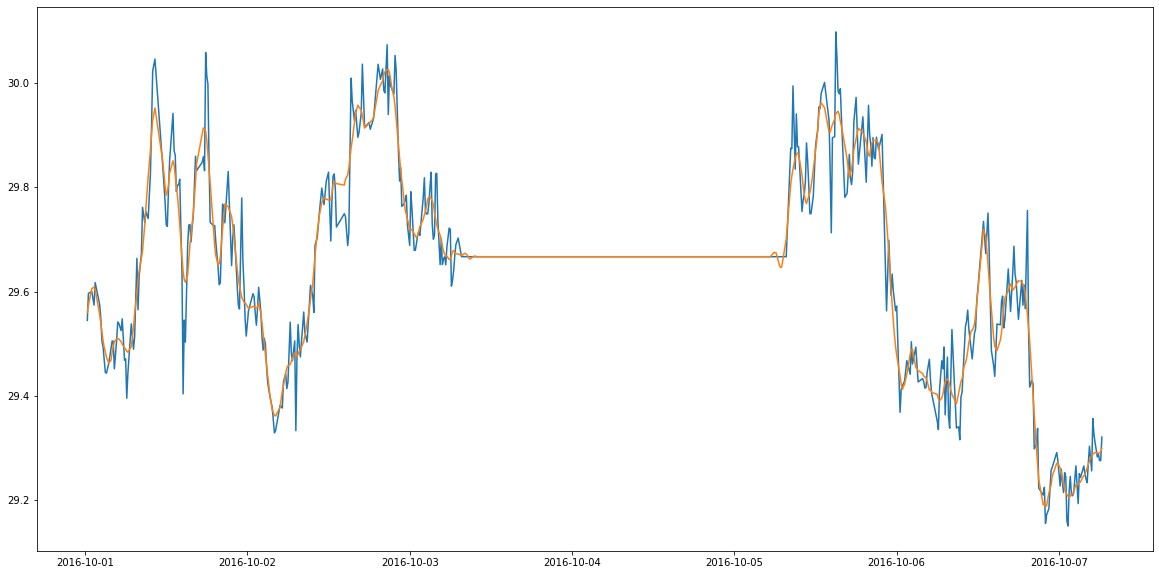

In [23]:
plt.figure(figsize=(20,10))
plt.plot(temp3.sort_index())
plt.plot(y_train.sort_index())
plt.show()

## Análisis de componentes principales (PCA)

In [24]:
from sklearn.decomposition import PCA
if pca_select:
    pca = PCA(n_components=20)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

## Entrenamiento del modelo
### Usamos validaciones cruzadas con los datos de entrenamiento para evaluar el error.
#### Ajustamos los parámetros en esta fase


In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.metrics.regression import mean_squared_error
from math import sqrt

if model_select == 'GradientBoosting':
    model = GradientBoostingRegressor(n_estimators=600, learning_rate=0.1,max_depth=4, loss='lad')
elif model_select == 'RandomForest':
    model = RandomForestRegressor(n_estimators=100, criterion='mse')
else:
    print ("ERROR!!: Error al especificar el modelo. [Opciones --> RandomForest / GradientBoosting]")

### Evaluación del error de entrenamiento

In [28]:
print ("\nTaining error")
splits = 2
kf = KFold(n_splits=splits)

error_medio = 0.0
for train, test in kf.split(X_train, y_train):
    model.fit(X_train.values[train], y_train.values[train].ravel())
    predictions = model.predict(X_train.values[test])
    nrmse = (sqrt(mean_squared_error(y_train.values[test], predictions)) / (max(y_train.values) - min(y_train.values)))
    print ("RMSE Normalized: "+str(nrmse))
    error_medio += nrmse

print ("error medio validaciones cruzadas: "+str(error_medio / splits))


Taining error
RMSE Normalized: [0.06427554]
RMSE Normalized: [0.05022529]
error medio validaciones cruzadas: [0.05725041]


## Validación del modelo
### Usar los datos guardados previamente para test

In [29]:
model.fit(X_train.values,y_train.values.ravel())
predictions = model.predict(X_test.values)
nrmse = (np.sqrt(mean_squared_error(y_test.values,predictions)) / (max(y.values)-min(y.values)))
print ("RMSE Normalized: "+ str(nrmse))

RMSE Normalized: 0.047168637250533496


### Visualización del error
#### Se plantean tres visualizaciones:
##### 1- Comparación de medida real y estimada
##### 2- Error de predicción para cada punto
##### 3- Distribución de errores

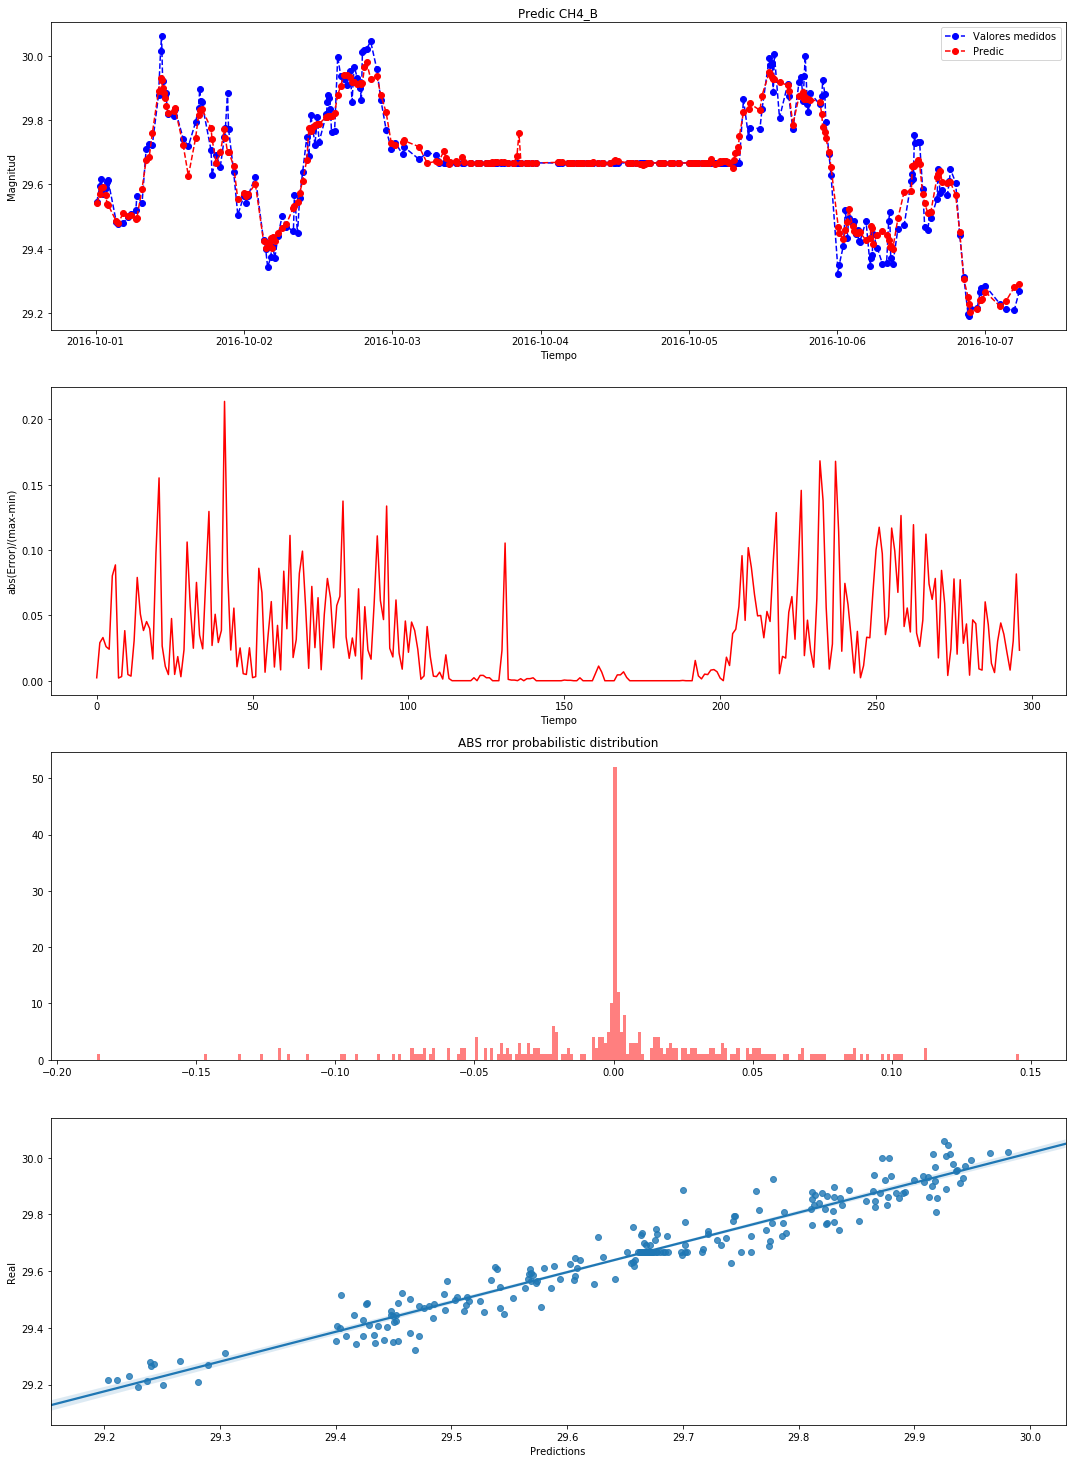

In [30]:
plt.figure(figsize=(15,20))

plt.subplot(411)
plt.title('Predic ' + target)

plt.plot(y_test.sort_index().index,y_test.sort_index().values, 'b--o', label='Valores medidos')
plt.plot(y_test.sort_index().index,pd.DataFrame(predictions,index=y_test.index).sort_index().values, 'r--o', label='Predic')
plt.xlabel('Tiempo')
plt.ylabel('Magnitud')
plt.legend()
plt.subplot(412)
plt.plot(pd.DataFrame((np.abs(predictions - y_test.values)/ (np.max(y_test.values) - np.min(y_test.values))),index=y_test.index).sort_index().values , 'r')
plt.xlabel('Tiempo')
plt.ylabel('abs(Error)/(max-min)')
plt.subplot(413)
# plt.hist(np.subtract(array_real,array_forecast_tsne),bins = 300,color = 'g', alpha = 0.5)
plt.hist(predictions - y_test.values, bins=300, color='r', alpha=0.5)
# plt.hist(np.subtract(array_real,array_forecast_pca),bins = 300,color = 'r', alpha = 0.5)
plt.title('ABS rror probabilistic distribution')
plt.tight_layout()
plt.subplot(414)
sns.regplot(predictions,y_test.values)
plt.xlabel('Predictions')
plt.ylabel('Real')
plt.show()